In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import re
import ast
import string
import unidecode
from collections import defaultdict
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, concatenate, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from nltk import word_tokenize
from nltk.corpus import stopwords

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
with open("../data/word2idx/word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)
    #Map any unknown word to UNKNOWN, which has index 1

In [3]:
len(word2idx)

445881

In [4]:
data = pd.read_csv('../data/sample_data_1percent.csv')

In [5]:
conditions = data.link_anchor.str.contains('#', na=False)
data = data[~conditions]
data = data.reset_index().drop('index', axis=1)

In [6]:
data.head()

,text,link_anchor,link_start,link_end,target_wikidata,tokenized_vector,candidates
0,the academy awards also officially and popular...,film industry,120,133,1415395,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[93196.0, 2973146.0, 2973208.0, 2973157.0, 328..."
1,the academy awards also officially and popular...,academy of motion picture arts and sciences,156,199,212329,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[212329.0, 212329.0]"
2,the academy awards also officially and popular...,art deco,551,559,173782,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[173782.0, 4824850.0, 4796770.0, 23307613.0, 2..."
3,the academy awards also officially and popular...,george stanley,603,617,5544783,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[3101928.0, 5539480.0, 5544780.0, 5544779.0, 5..."
4,the academy awards also officially and popular...,cedric gibbons,642,656,727904,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[727904.0, 5057103.0]"


In [7]:
data.shape

(2459381, 7)

In [9]:
# with open('../data/sample_doc2vec_data.pkl', 'rb') as f:
#     docs = pickle.load(f)

In [10]:
# with open('../data/sample_labels.pkl', 'rb') as f:
#     data = pickle.load(f)

In [8]:
with open('../data/knowledge_graph_data/id2text_entity.pickle', 'rb') as f:
    id2text = pickle.load(f)

In [9]:
with open('../data/name_to_wiki_id.pkl', 'rb') as f:
    name_to_wiki_id = pickle.load(f)

In [10]:
with open('../data/knowledge_graph_data/idx2id_entity.pickle', 'rb') as f:
    idx2id = pickle.load(f)

In [11]:
id2idx = {value: key for key, value in idx2id.items()}

In [12]:
graph_embedding = np.load('../data/knowledge_graph_data/wiki_DistMult_entity.npy') 

In [13]:
# replace words within paranthesis and remove non alphanumeric characters
# get_rid of `the` which can cause difference
pattern = re.compile(r'\([^)]*\)|[^a-zA-Z0-9 -]|\s|(^|[^a-zA-Z0-9])the[^a-zA-Z0-9]')
# unidecode to remove accents
normalize_text = lambda text: pattern.sub("", unidecode.unidecode(text).lower())


In [14]:
#window length actually 2 times this since from both sides
window_length = 10

In [ ]:
#For each of the entities in each of the rows, make word2idx vector using context window and also get graph embedding.

lstm_input = []
graph_input = []
# doc_input = []
response = []
not_in_graph = []

lstm_input_list = []
# corresponds to each candidate
graph_input_list = []

for i, article in tqdm_notebook(data.iterrows(), total = len(data)):
    text = article['text']
#     doc_embedding = docs[i][0]
#     for entity, indices in article[1].items():
    name = article['link_anchor']
    entity_id = article['target_wikidata']
    #Don't include actual entity text for now in context window since doing fixed length? 
    indices = np.array([int(c) for c in list(article['tokenized_vector']) if c.isdigit()])
    entity_idx = np.where(indices == 1)[0]
    if len(entity_idx):
        split_text = text.split()
        context = split_text[max(0, entity_idx.min() - window_length) : entity_idx.min()] +\
                  split_text[entity_idx.max() + 1 : entity_idx.max() + window_length + 1] 
        #if word not in vocab, by default map to 1
        context_word2idx = [word2idx.get(word, 1) for word in context]
        
        #storing list of candidates in knowledge graph
        kge_candidates = []
        
        #get a candidate from candidate_dict to get a false, irrelevant entity for each entity
        if not pd.isnull(article['candidates']):
            candidates_list = ast.literal_eval(article['candidates'])[:10]
            #can't choose actual entity as false 
            if entity_id in candidates_list:
                candidates_list.remove(entity_id)
            if len(candidates_list) > 0:
                for false_entity_id in candidates_list:
                    if false_entity_id in id2idx:
                        false_graph_embed = graph_embedding[id2idx[false_entity_id]]
                        lstm_input.append(context_word2idx)
                        graph_input.append(false_graph_embed)
        #                 doc_input.append(doc_embedding)
                        response.append(0)
                        kge_candidates.append(false_graph_embed)
                    else:
                        not_in_graph.append(false_entity_id)
        if entity_id in id2idx:
            true_graph_embed = graph_embedding[id2idx[entity_id]]
            lstm_input.append(context_word2idx)
            graph_input.append(true_graph_embed)
    #         doc_input.append(doc_embedding)
            response.append(1)
            # this means that last index is always the true embedding
            kge_candidates.append(true_graph_embed)
            lstm_input_list.append(context_word2idx)
            graph_input_list.append(kge_candidates)
        
        else:
            not_in_graph.append(entity_id)
            
lstm_input = pad_sequences(lstm_input, maxlen = window_length * 2, padding = 'post')
graph_input = np.array(graph_input)
# doc_input = np.array(doc_input)
response = np.array(response)

In [29]:
# np.save("../data/model1/lstm_input.pkl", lstm_input)
# np.save("../data/model1/graph_input.pkl", graph_input)
# np.save("../data/model1/response.pkl", response)

In [ ]:
lstm_input_list = np.array(lstm_input_list)
graph_input_list = np.array(graph_input_list)

In [ ]:
np.save("../data/model1/lstm_input_list.npy", lstm_input_list)
np.save("../data/model1/graph_input_list.npy", graph_input_list)

In [10]:
lstm_input = np.load("../data/model1/lstm_input.pkl.npy")
graph_input = np.load("../data/model1/graph_input.pkl.npy")
response = np.load("../data/model1/response.pkl.npy")

In [11]:
len(graph_input)

11793058

In [12]:
len(lstm_input)

11793058

In [13]:
len(response)

11793058

In [14]:
response.mean()

0.199529672456457

In [8]:
len(not_in_graph)

NameError: name 'not_in_graph' is not defined

In [36]:
len(not_in_graph) / len(graph_input)

0.03272645653061318

In [15]:
np.random.seed(1)

train_ind, test_ind = train_test_split(np.arange(len(response)))
lstm_train = lstm_input[train_ind]
lstm_test = lstm_input[test_ind]
graph_train = graph_input[train_ind]
graph_test = graph_input[test_ind]
# doc_train = doc_input[train_ind]
# doc_test = doc_input[test_ind]
y_train = response[train_ind]
y_test = response[test_ind]

len(y_train), len(y_test)

(8844793, 2948265)

In [16]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)

In [20]:
inp1 = Input(shape = (lstm_input.shape[1], ))
embed = Embedding(output_dim=150, input_dim=len(word2idx), input_length=lstm_input.shape[1])(inp1)
embed = Dropout(rate = 0.2)(embed)
out1 = LSTM(256)(embed)
w = out1
w = Dropout(0.2)(w)
w = Dense(128, activation = 'relu')(w)
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp1], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 20, 150)           66882150  
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               416768    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [21]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([lstm_train], y_train, batch_size = 8192, epochs = 4, validation_split = 0.2, class_weight = weights)

Train on 7075834 samples, validate on 1768959 samples
Epoch 1/4
7075834/7075834 [==============================] - 263s 37us/step - loss: 0.4905 - acc: 0.8002 - val_loss: 0.4842 - val_acc: 0.8013
Epoch 2/4
7075834/7075834 [==============================] - 261s 37us/step - loss: 0.4800 - acc: 0.8011 - val_loss: 0.4842 - val_acc: 0.8011
Epoch 3/4
7075834/7075834 [==============================] - 261s 37us/step - loss: 0.4726 - acc: 0.8019 - val_loss: 0.4870 - val_acc: 0.8006
Epoch 4/4
7075834/7075834 [==============================] - 261s 37us/step - loss: 0.4655 - acc: 0.8032 - val_loss: 0.4927 - val_acc: 0.7976


In [23]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])

# perfomance without knowledge graph embedding

y_test_pred = model.predict([lstm_test])

y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.7971908902354435

In [24]:
cm = confusion_matrix(y_test, y_test_pred)

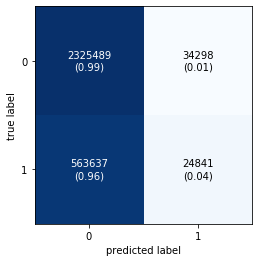

In [26]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [43]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [28]:
graph_input.shape

(11793058, 250)

In [31]:
inp2 = Input(shape = (graph_input.shape[1], ))
# inp3 = Input(shape = (doc_input.shape[1], ))
w = inp2
w = Dropout(0.2)(w)
w = Dense(256, activation = 'relu')(w)
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp2], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 250)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               64256     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 64,513
Trainable params: 64,513
Non-trainable params: 0
_________________________________________________________________


In [39]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([graph_train], y_train, batch_size = 8192, epochs = 30, validation_split = 0.2, class_weight = weights)

Train on 7075834 samples, validate on 1768959 samples
Epoch 1/30
7075834/7075834 [==============================] - 8s 1us/step - loss: 0.3890 - acc: 0.8329 - val_loss: 0.3692 - val_acc: 0.8376
Epoch 2/30
7075834/7075834 [==============================] - 8s 1us/step - loss: 0.3883 - acc: 0.8331 - val_loss: 0.3687 - val_acc: 0.8382
Epoch 3/30
7075834/7075834 [==============================] - 8s 1us/step - loss: 0.3875 - acc: 0.8335 - val_loss: 0.3683 - val_acc: 0.8382
Epoch 4/30
7075834/7075834 [==============================] - 8s 1us/step - loss: 0.3867 - acc: 0.8337 - val_loss: 0.3667 - val_acc: 0.8389
Epoch 5/30
7075834/7075834 [==============================] - 8s 1us/step - loss: 0.3862 - acc: 0.8339 - val_loss: 0.3670 - val_acc: 0.8385
Epoch 6/30
7075834/7075834 [==============================] - 8s 1us/step - loss: 0.3855 - acc: 0.8340 - val_loss: 0.3667 - val_acc: 0.8385
Epoch 7/30
7075834/7075834 [==============================] - 8s 1us/step - loss: 0.3849 - acc: 0.8343 - v

In [40]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])

# perfomance without word embedding

y_test_pred = model.predict([graph_test])

y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8411214731375911

In [41]:
cm = confusion_matrix(y_test, y_test_pred)

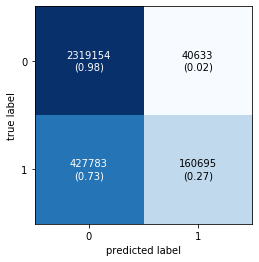

In [42]:
plot_confusion_matrix(cm, show_normed = True);

In [ ]:
# retrain new model

In [107]:
inp1 = Input(shape = (lstm_input.shape[1], ))
inp2 = Input(shape = (graph_input.shape[1], ))
# inp3 = Input(shape = (doc_input.shape[1], ))
embed = Embedding(output_dim=100, input_dim=len(word2idx), input_length=lstm_input.shape[1])(inp1)
out1 = LSTM(128)(embed)
w = concatenate([out1, inp2])
w = Dense(256, activation = 'relu')(w)
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp1, inp2], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 20, 100)      44588100    input_19[0][0]                   
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 128)          117248      embedding_10[0][0]               
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
concatenat

In [108]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([lstm_train, graph_train], y_train, batch_size = 8192, epochs = 4, validation_split = 0.2, class_weight = weights)

Train on 7075834 samples, validate on 1768959 samples
Epoch 1/4


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_11/Adam/mul_16}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_11/acc/Mean_1/_1673]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_11/Adam/mul_16}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred_prob = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [ ]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

In [ ]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [96]:
# inp1 = Input(shape = (lstm_input.shape[1], ))
# inp2 = Input(shape = (graph_input.shape[1], ))
# # inp3 = Input(shape = (doc_input.shape[1], ))
# embed = Embedding(output_dim=128, input_dim=len(word2idx), input_length=lstm_input.shape[1])(inp1)
# out1 = LSTM(128)(embed)
# w = concatenate([out1, inp2])
# w = Dense(128, activation = 'relu')(w)
# w = Dropout(0.2)(w)
# w = Dense(64, activation = 'relu')(w)
# w = Dropout(0.2)(w)
# w = Dense(32, activation = 'relu')(w)
# w = Dropout(0.2)(w)
# out = Dense(1, activation = 'sigmoid')(w)
# model = Model(inputs=[inp1, inp2], outputs=out)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 20, 128)      57072768    input_15[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 128)          131584      embedding_8[0][0]                
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
concatenat

In [97]:
# # model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
# model.fit([lstm_train, graph_train], y_train, batch_size = 8192, epochs = 4, validation_split = 0.2, class_weight = weights)

Train on 7075834 samples, validate on 1768959 samples
Epoch 1/4
7075834/7075834 [==============================] - 248s 35us/step - loss: 0.4011 - acc: 0.8251 - val_loss: 0.3412 - val_acc: 0.8467
Epoch 2/4
7075834/7075834 [==============================] - 244s 35us/step - loss: 0.3334 - acc: 0.8494 - val_loss: 0.3199 - val_acc: 0.8555
Epoch 3/4
7075834/7075834 [==============================] - 244s 35us/step - loss: 0.3016 - acc: 0.8619 - val_loss: 0.3136 - val_acc: 0.8583
Epoch 4/4
7075834/7075834 [==============================] - 245s 35us/step - loss: 0.2769 - acc: 0.8727 - val_loss: 0.3205 - val_acc: 0.8580


In [98]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred_prob = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8578384236152449

In [100]:
cm = confusion_matrix(y_test, y_test_pred)

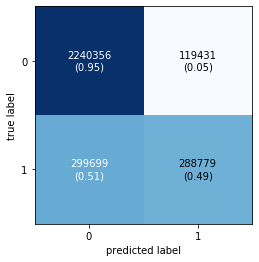

In [101]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [102]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.8862756502902215

In [103]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

Text(0.5, 1.0, 'ROC curve')

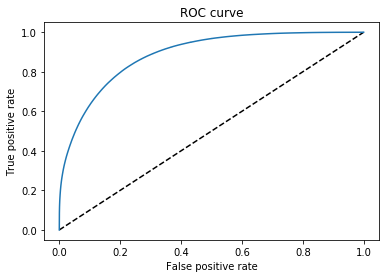

In [104]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [ ]:
def compute_abstain_threshold()

In [72]:
print('hi')

hi


In [ ]:
def 

In [40]:
# model.save('../data/model1/model.h5')

# np.save("../data/model1/lstm_train", lstm_train)
# np.save("../data/model1/lstm_iest", lstm_test)

# np.save("../data/model1/graph_train", graph_train)
# np.save("../data/model1/graph_test", graph_test)

# np.save("../data/model1/y_train", y_train)
# np.save("../data/model1/y_test", y_test)

In [ ]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred > 0.25, 1, 0)
accuracy_score(y_test, y_test_pred)

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);